In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
tf.__version__

TensorFlow 2.x selected.


'2.0.0'

In [2]:
# example data
words = ['good', 'so good', 'nice', 'oh no' , 'bad', 'worse']
y_data = [1,1,1,0,0,0]

# creating a token dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'n', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'g', 8: 'h', 9: 'i', 10: 'n', 11: 'o', 12: 'r', 13: 's', 14: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'g': 7, 'h': 8, 'i': 9, 'n': 10, 'o': 11, 'r': 12, 's': 13, 'w': 14}


In [3]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda word : [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word : len(word), x_data))

print(x_data)
print(x_data_len)

[[7, 11, 11, 5], [13, 11, 1, 7, 11, 11, 5], [10, 9, 4, 6], [11, 8, 1, 10, 11], [3, 2, 5], [14, 11, 12, 13, 6]]
[4, 7, 4, 5, 3, 5]


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
max_sequence = 10
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence,
                       padding = 'post', truncating = 'post')

# checking data
print(x_data)
print(x_data_len)
print(y_data)

[[ 7 11 11  5  0  0  0  0  0  0]
 [13 11  1  7 11 11  5  0  0  0]
 [10  9  4  6  0  0  0  0  0  0]
 [11  8  1 10 11  0  0  0  0  0]
 [ 3  2  5  0  0  0  0  0  0  0]
 [14 11 12 13  6  0  0  0  0  0]]
[4, 7, 4, 5, 3, 5]
[1, 1, 1, 0, 0, 0]


Create Model


In [143]:
# creating simple rnn for "many to one" classification
input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))
hidden_size = 10
num_classes = 2

model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, 
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(keras.layers.SimpleRNN(units=hidden_size))
model.add(keras.layers.Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 15)          225       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 10)                260       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 22        
Total params: 507
Trainable params: 282
Non-trainable params: 225
_________________________________________________________________


Training model

In [0]:
# creating loss function
def loss_fn(y, h):
  return keras.losses.sparse_categorical_crossentropy(y, h)
    
# creating an optimizer
opt = keras.optimizers.SGD(learning_rate = 0.01)

def fit(x, y):
  with tf.GradientTape() as tape:
    h = model(x)
    tr_loss = loss_fn(y, h)
  grads = tape.gradient(target=tr_loss, sources=model.variables)
  opt.apply_gradients(grads_and_vars=zip(grads, model.variables))  
  return tr_loss

In [148]:
batch_size = 3
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.batch(batch_size = batch_size)
print(tr_dataset)
tr_loss_hist = []

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.int32, tf.int32)>


In [149]:
# training
for epoch in range(30):            
    for x, y in tr_dataset:        
        tr_loss = fit(x, y)        
        tr_loss_hist.append(tr_loss.numpy())
    if epoch % 5 ==0:
        print(epoch, np.mean(tr_loss_hist))

0 0.10039502
5 0.08979972
10 0.08144202
15 0.07466718
20 0.069053516
25 0.06431775


In [150]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('acc : {:.2%}'.format(np.mean(yhat == y_data)))

acc : 100.00%


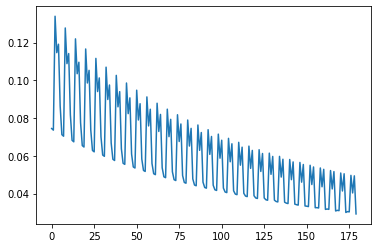

In [151]:
plt.plot(np.concatenate(tr_loss_hist))

In [152]:
yhat, y_data

(array([1, 1, 1, 0, 0, 0]), [1, 1, 1, 0, 0, 0])